In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from tensorflow.keras.layers import Input, Dense, Flatten,Conv2D, Dropout, BatchNormalization, MaxPooling2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential

import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt


In [2]:
def preprocess_input_new(x):

    img = keras.applications.mobilenet.preprocess_input(img_to_array(x), data_format=None)
    return image.array_to_img(img)

def accuracy_loss(prediction, labels):
    total_correct = 0
    total_failed = 0
    total = len(prediction)
    counter = 0
    
    for key in labels:
        if labels[key] == prediction[counter]:
            total_correct += 1
        else: 
            total_failed += 1
        counter+=1 
        
    accuracy = round(total_correct / total, 4)
    loss = round(total_failed / total, 4)
    
    return accuracy, loss
        

def plot_show(history, title):


    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title + ' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title + ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    

In [3]:

class Data_loader:
    def __init__(self):
        pass
        
    def train_valid_loader(self, batch_size):
        
        dataflow_kwargs = dict(batch_size=batch_size)



        train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=40,
            horizontal_flip=True,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            validation_split=0.2
        )



        train_generator = train_datagen.flow_from_directory('dataset/German-Traffic-Signs-Dataset-GTSRB/Train',
                            subset="training",
                            shuffle=True,
                            target_size=(32,32),
                            **dataflow_kwargs)



        validation_generator = train_datagen.flow_from_directory('dataset/German-Traffic-Signs-Dataset-GTSRB/Train',
                                subset='validation',
                                shuffle=True,
                                target_size=(32,32),
                                **dataflow_kwargs)
        
        return train_generator, validation_generator


    def test_loader(self):
        
        
        test_directory = 'dataset/German-Traffic-Signs-Dataset-GTSRB/Test'
        test_datagen = ImageDataGenerator(rescale=1/255.)
        test_generator = test_datagen.flow_from_directory(test_directory,target_size=(32,32),
                         shuffle=False,
                         class_mode=None,
                         batch_size=1,
                         follow_links=False,

                         )
        
        df = pd.read_csv("dataset/German-Traffic-Signs-Dataset-GTSRB/Test.csv", usecols = ['ClassId','Path'])
        labels = dict(zip(df.Path, df.ClassId))

        
        return test_generator, labels

    
data_loader = Data_loader()


In [4]:

class CNN_Model:
    def __init__(self, model_type, learning_rate, optimizer):

        

        if model_type == 'transfer':
            
            base_model = tf.keras.applications.MobileNetV2(input_shape=(32,32,3),
                       include_top=False,
                       weights='imagenet')
            
            base_model.trainable = False
            base_model.summary()

        
            top_model = base_model.output
            top_model = Flatten(name="flatten")(top_model)
            top_model = Dense(4096, activation='relu')(top_model)
            top_model = Dense(1072, activation='relu')(top_model)
            top_model = Dropout(0.2)(top_model)
            output_layer = Dense(43, activation='softmax')(top_model)

            self.model = Model(inputs=base_model.input, outputs=output_layer)

        
        
        elif model_type == 'simple':
            
            self.model = Sequential()
            self.model.add(Conv2D(32, (3, 3), padding='same',
                             input_shape=(32,32,3)))
            self.model.add(Activation('relu'))
            self.model.add(Conv2D(32, (3, 3)))
            self.model.add(Activation('relu'))
            self.model.add(MaxPooling2D(pool_size=(2, 2)))
            self.model.add(Conv2D(64, (3, 3), padding='same'))
            self.model.add(Activation('relu'))
            self.model.add(Conv2D(64, (3, 3)))
            self.model.add(Activation('relu'))
            self.model.add(MaxPooling2D(pool_size=(2, 2)))
            self.model.add(Flatten())
            self.model.add(Dense(512))
            self.model.add(Activation('relu'))
            self.model.add(Dense(43, activation='softmax'))
            
        elif model_type == 'dopout':
              
            self.model = Sequential()
            self.model.add(Conv2D(32, (3, 3), padding='same',
                             input_shape=(32,32,3)))
            self.model.add(Activation('relu'))
            self.model.add(Conv2D(32, (3, 3)))
            self.model.add(Activation('relu'))
            self.model.add(MaxPooling2D(pool_size=(2, 2)))
            self.model.add(Conv2D(64, (3, 3), padding='same'))
            self.model.add(Activation('relu'))
            self.model.add(Conv2D(64, (3, 3)))
            self.model.add(Activation('relu'))
            self.model.add(MaxPooling2D(pool_size=(2, 2)))
            self.model.add(Dropout(0.25))
            self.model.add(Flatten())
            self.model.add(Dense(512))
            self.model.add(Activation('relu'))
            self.model.add(Dropout(0.5))
            self.model.add(Dense(43, activation='softmax'))
            
            
        elif model_type == 'batch_norm':
                             
            self.model = Sequential()
            self.model.add(BatchNormalization(input_shape=(32,32,3)))
            self.model.add(Conv2D(32, (3, 3), padding='same',
                             input_shape=(32,32,3)))
            self.model.add(Activation('relu'))
            self.model.add(Conv2D(32, (3, 3)))
            self.model.add(Activation('relu'))
            self.model.add(MaxPooling2D(pool_size=(2, 2)))
            self.model.add(Conv2D(64, (3, 3), padding='same'))
            self.model.add(Activation('relu'))
            self.model.add(Conv2D(64, (3, 3)))
            self.model.add(Activation('relu'))
            self.model.add(BatchNormalization())
            self.model.add(MaxPooling2D(pool_size=(2, 2)))
            self.model.add(Dropout(0.25))
            self.model.add(Flatten())
            self.model.add(Dense(512))
            self.model.add(Activation('relu'))
            self.model.add(Dropout(0.5))
            self.model.add(Dense(43, activation='softmax'))
            
            
            
        lr_schedule = optimizers.schedules.ExponentialDecay(
                initial_learning_rate=learning_rate,
                decay_steps=10000,
                decay_rate=0.9)
        
        if optimizer == 'SGD':
           
            opt = optimizers.SGD(learning_rate=lr_schedule)
            
        elif optimizer == 'RMS':
            
            opt = optimizers.RMSprop(learning_rate=lr_schedule)
            
        elif optimizer == 'ADAM':
            opt = optimizers.Adam(learning_rate=lr_schedule)

            
            
        self.model.compile(opt, loss="categorical_crossentropy", metrics=["accuracy",tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

            
            
            
    def training(self, train_generator, validation_generator):

        STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
        STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

        history = self.model.fit(train_generator,
                            steps_per_epoch = STEP_SIZE_TRAIN,
                            validation_data = validation_generator,
                            validation_steps = STEP_SIZE_VALID,
                            epochs=10

        )
        return history
        
    def test(self, test_generator):
        
        predict_x = self.model.predict(test_generator) 
        prediction = np.argmax(predict_x,axis=1)
        
        return prediction

    def transfer_learning(self, train_generator, validation_generator):

        STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
        STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

        history = self.model.fit(
                train_generator,
                epochs = 10,
                validation_data = validation_generator,
                steps_per_epoch = STEP_SIZE_TRAIN,
                validation_steps = STEP_SIZE_VALID,
                )
        return history
  

In [5]:
# ================================ DIFFERENT BATCH SIZES ================================

    

# ===================== BATCH SIZE 16 =======================
print('===================== BATCH SIZE 16 =======================')
train_generator, validation_generator = data_loader.train_valid_loader(16)

model = CNN_Model(model_type='simple', learning_rate=0.001, optimizer='ADAM')
training = model.training(train_generator, validation_generator)

# ===================== BATCH SIZE 64 =======================
print('===================== BATCH SIZE 64 =======================')

train_generator, validation_generator = data_loader.train_valid_loader(64)
model = CNN_Model(model_type='simple', learning_rate=0.001, optimizer='ADAM')
training = model.training(train_generator, validation_generator)

# ===================== BATCH SIZE 128 =======================
print('===================== BATCH SIZE 128 =======================')
# ===================== BEST BATCH SIZE =======================
train_generator, validation_generator = data_loader.train_valid_loader(128)
model = CNN_Model(model_type='simple', learning_rate=0.001, optimizer='ADAM')
training = model.training(train_generator, validation_generator)



===================== BATCH SIZE 16 =======================
Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.
Epoch 1/10
1960/1960 [==============================] - 99s 50ms/step - loss: 2.2427 - accuracy: 0.3637 - precision: 0.7233 - recall: 0.1881 - val_loss: 1.8150 - val_accuracy: 0.4545 - val_precision: 0.6921 - val_recall: 0.3093
Epoch 2/10
1960/1960 [==============================] - 96s 49ms/step - loss: 1.1659 - accuracy: 0.6195 - precision: 0.7987 - recall: 0.4719 - val_loss: 1.4786 - val_accuracy: 0.5454 - val_precision: 0.7152 - val_recall: 0.4298
Epoch 3/10
1960/1960 [==============================] - 101s 52ms/step - loss: 0.8867 - accuracy: 0.7032 - precision: 0.8243 - recall: 0.5995 - val_loss: 1.2591 - val_accuracy: 0.6242 - val_precision: 0.7528 - val_recall: 0.5230
Epoch 4/10
1960/1960 [==============================] - 95s 49ms/step - loss: 0.7688 - accuracy: 0.7495 - precision: 0.8387 - recall: 0.6683 - val_loss: 1.2688 - val_ac

In [6]:
# ================================ DIFFERENT LEARNING RATES ================================


test_generator, true_labels = data_loader.test_loader()
train_generator, validation_generator = data_loader.train_valid_loader(128)

# ===================== LEARNING RATE SECTION =======================
# ===================== LEARNING RATE : 0.01 =======================
print('===================== LEARNING RATE : 0.01 =======================')
model = CNN_Model(model_type='simple', learning_rate=0.01, optimizer='ADAM')
training = model.training(train_generator, validation_generator)


# ===================== LEARNING RATE : 0.001 =======================
print('===================== LEARNING RATE : 0.001 =======================')
# ===================== BEST LEARNING RATE =======================
model = CNN_Model(model_type='simple', learning_rate=0.001, optimizer='ADAM')
training = model.training(train_generator, validation_generator)


# ===================== LEARNING RATE : 0.0001 =======================
print('===================== LEARNING RATE : 0.0001 =======================')
# ===================== SECOND BEST LEARNING RATE =======================
model = CNN_Model(model_type='simple', learning_rate=0.0001, optimizer='ADAM')
training = model.training(train_generator, validation_generator)



Found 12630 images belonging to 1 classes.
Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.
===================== LEARNING RATE : 0.01 =======================
Epoch 1/10
245/245 [==============================] - 69s 280ms/step - loss: 5.4756 - accuracy: 0.0547 - precision_3: 0.0254 - recall_3: 2.8809e-04 - val_loss: 3.4919 - val_accuracy: 0.0575 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/10
245/245 [==============================] - 67s 275ms/step - loss: 3.4914 - accuracy: 0.0558 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 3.4925 - val_accuracy: 0.0552 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 3/10
245/245 [==============================] - 70s 286ms/step - loss: 3.4912 - accuracy: 0.0552 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 3.4887 - val_accuracy: 0.0565 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 4/10
245/245 [==============================] - 

In [7]:
# ================================ DIFFERENT OPTIMIZERS ================================

# ===================== optimizer section =======================
print('===================== ADAM OPTIMIZER =======================')
# ===================== SECOND BEST RMS OPTIMIZER =======================
model = CNN_Model(model_type='simple', learning_rate=0.001, optimizer='ADAM')
training = model.training(train_generator, validation_generator)


print('===================== SGD OPTIMIZER =======================')
model = CNN_Model(model_type='simple', learning_rate=0.001, optimizer='SGD')
training = model.training(train_generator, validation_generator)


print('===================== RMS OPTIMIZER =======================')
# ===================== BEST RMS OPTIMIZER =======================
model = CNN_Model(model_type='simple', learning_rate=0.001, optimizer='RMS')
training = model.training(train_generator, validation_generator)


===================== ADAM OPTIMIZER =======================
Epoch 1/10
245/245 [==============================] - 69s 278ms/step - loss: 3.4091 - accuracy: 0.2418 - precision_6: 0.5574 - recall_6: 0.0777 - val_loss: 2.4564 - val_accuracy: 0.3078 - val_precision_6: 0.5658 - val_recall_6: 0.1150
Epoch 2/10
245/245 [==============================] - 67s 272ms/step - loss: 1.6988 - accuracy: 0.4850 - precision_6: 0.7398 - recall_6: 0.2859 - val_loss: 1.9856 - val_accuracy: 0.4340 - val_precision_6: 0.6122 - val_recall_6: 0.2967
Epoch 3/10
245/245 [==============================] - 67s 272ms/step - loss: 1.2447 - accuracy: 0.6053 - precision_6: 0.7821 - recall_6: 0.4414 - val_loss: 1.7965 - val_accuracy: 0.5087 - val_precision_6: 0.6591 - val_recall_6: 0.3995
Epoch 4/10
245/245 [==============================] - 67s 275ms/step - loss: 0.9799 - accuracy: 0.6838 - precision_6: 0.8144 - recall_6: 0.5515 - val_loss: 1.7263 - val_accuracy: 0.5380 - val_precision_6: 0.6694 - val_recall_6: 0.4481

===================== SIMPLE MODEL =======================
Epoch 1/10
245/245 [==============================] - 70s 282ms/step - loss: 3.6260 - accuracy: 0.1668 - precision_9: 0.4098 - recall_9: 0.0410 - val_loss: 2.8323 - val_accuracy: 0.2147 - val_precision_9: 0.4237 - val_recall_9: 0.0637
Epoch 2/10
245/245 [==============================] - 73s 297ms/step - loss: 2.0145 - accuracy: 0.4060 - precision_9: 0.7216 - recall_9: 0.2160 - val_loss: 1.9276 - val_accuracy: 0.4392 - val_precision_9: 0.6613 - val_recall_9: 0.2914
Epoch 3/10
245/245 [==============================] - 70s 283ms/step - loss: 1.3946 - accuracy: 0.5599 - precision_9: 0.7792 - recall_9: 0.3888 - val_loss: 1.7228 - val_accuracy: 0.5077 - val_precision_9: 0.6974 - val_recall_9: 0.3826
Epoch 4/10
245/245 [==============================] - 70s 286ms/step - loss: 1.0362 - accuracy: 0.6649 - precision_9: 0.8095 - recall_9: 0.5314 - val_loss: 1.6208 - val_accuracy: 0.5549 - val_precision_9: 0.6983 - val_recall_9: 0.4242
E

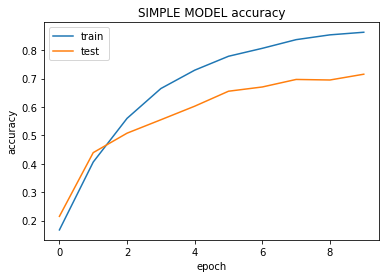

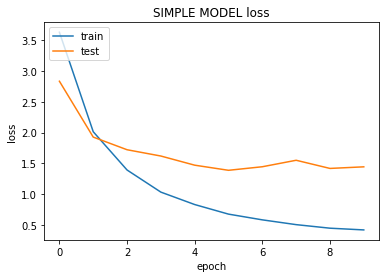

========= accuracy of the best model on testset
accuracy : 0.0038 loss : 0.9962
===================== WITH DOPOUT LAYER =======================
Epoch 1/10
245/245 [==============================] - 73s 292ms/step - loss: 3.6319 - accuracy: 0.1149 - precision_10: 0.3405 - recall_10: 0.0194 - val_loss: 2.9763 - val_accuracy: 0.1977 - val_precision_10: 0.5599 - val_recall_10: 0.0329
Epoch 2/10
245/245 [==============================] - 70s 284ms/step - loss: 2.4708 - accuracy: 0.3069 - precision_10: 0.6767 - recall_10: 0.1266 - val_loss: 2.2213 - val_accuracy: 0.3584 - val_precision_10: 0.6517 - val_recall_10: 0.1860
Epoch 3/10
245/245 [==============================] - 69s 282ms/step - loss: 1.7891 - accuracy: 0.4554 - precision_10: 0.7528 - recall_10: 0.2749 - val_loss: 1.5808 - val_accuracy: 0.5079 - val_precision_10: 0.7863 - val_recall_10: 0.3087
Epoch 4/10
245/245 [==============================] - 69s 283ms/step - loss: 1.4034 - accuracy: 0.5571 - precision_10: 0.7822 - recall_10: 

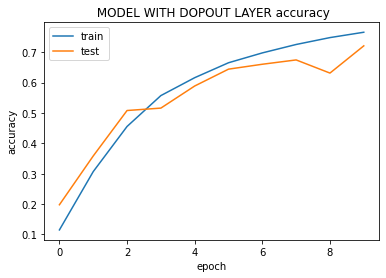

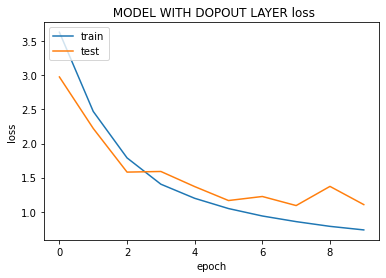

===================== WITH BATCH NORMALIZATION LAYER =======================
Epoch 1/10
245/245 [==============================] - 73s 295ms/step - loss: 2.6831 - accuracy: 0.2627 - precision_11: 0.6514 - recall_11: 0.1056 - val_loss: 3.2279 - val_accuracy: 0.2216 - val_precision_11: 1.0000 - val_recall_11: 0.0031
Epoch 2/10
245/245 [==============================] - 73s 297ms/step - loss: 1.7342 - accuracy: 0.4591 - precision_11: 0.7324 - recall_11: 0.2874 - val_loss: 2.0896 - val_accuracy: 0.4230 - val_precision_11: 0.9665 - val_recall_11: 0.1219
Epoch 3/10
245/245 [==============================] - 73s 299ms/step - loss: 1.3186 - accuracy: 0.5718 - precision_11: 0.7808 - recall_11: 0.4214 - val_loss: 1.6006 - val_accuracy: 0.4947 - val_precision_11: 0.7804 - val_recall_11: 0.3295
Epoch 4/10
245/245 [==============================] - 72s 294ms/step - loss: 1.0908 - accuracy: 0.6414 - precision_11: 0.8016 - recall_11: 0.5182 - val_loss: 1.3648 - val_accuracy: 0.5767 - val_precision_11

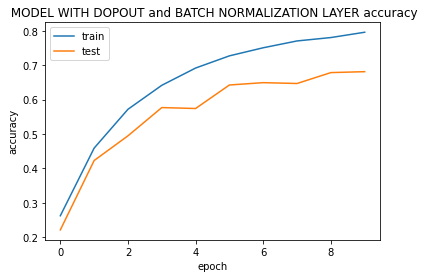

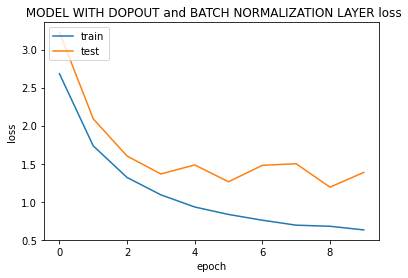

In [8]:

# ===================== DIFFERENT MODELS =======================
print('===================== SIMPLE MODEL =======================')
# ===================== BEST MODEL =======================
model = CNN_Model(model_type='simple', learning_rate=0.001, optimizer='RMS')
training = model.training(train_generator, validation_generator)
prediction = model.test(test_generator)
plot_show( training, 'SIMPLE MODEL' )

accuracy, loss = accuracy_loss(prediction, true_labels)
print('========= accuracy of the best model on testset')
print('accuracy : ' + str(accuracy), 'loss : ' + str(loss))

print('===================== WITH DOPOUT LAYER =======================')
model = CNN_Model(model_type='dopout', learning_rate=0.001, optimizer='RMS')
training = model.training(train_generator, validation_generator)
plot_show( training, ' MODEL WITH DOPOUT LAYER' )

print('===================== WITH BATCH NORMALIZATION LAYER =======================')
# ===================== SECOND BEST MODEL =======================
model = CNN_Model(model_type='batch_norm', learning_rate=0.001, optimizer='RMS')
training = model.training(train_generator, validation_generator)
plot_show( training, ' MODEL WITH DOPOUT and BATCH NORMALIZATION LAYER' )


===================== MOBILENET TRANSFER LEARNING =======================
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 16, 16, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 16, 16, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 16, 16, 32)   0           ['bn_Conv1[0][0]']               
     

Epoch 1/10
245/245 [==============================] - 54s 212ms/step - loss: 3.3032 - accuracy: 0.1001 - precision_12: 0.3050 - recall_12: 0.0014 - val_loss: 3.3381 - val_accuracy: 0.0916 - val_precision_12: 0.2581 - val_recall_12: 0.0010
Epoch 2/10
245/245 [==============================] - 51s 210ms/step - loss: 3.2345 - accuracy: 0.1117 - precision_12: 0.4343 - recall_12: 0.0028 - val_loss: 3.3552 - val_accuracy: 0.0975 - val_precision_12: 0.3171 - val_recall_12: 0.0017
Epoch 3/10
245/245 [==============================] - 52s 212ms/step - loss: 3.2181 - accuracy: 0.1157 - precision_12: 0.4670 - recall_12: 0.0032 - val_loss: 3.3270 - val_accuracy: 0.0886 - val_precision_12: 0.2162 - val_recall_12: 0.0010
Epoch 4/10
245/245 [==============================] - 51s 210ms/step - loss: 3.2082 - accuracy: 0.1139 - precision_12: 0.4000 - recall_12: 0.0020 - val_loss: 3.3307 - val_accuracy: 0.0941 - val_precision_12: 0.2857 - val_recall_12: 5.1230e-04
Epoch 5/10
245/245 [====================

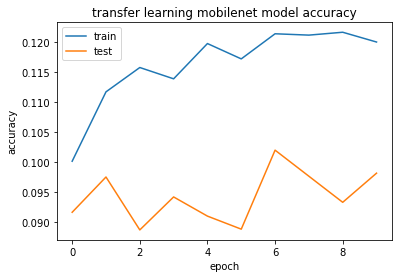

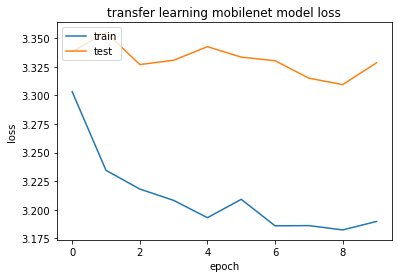

========= accuracy of mobilenet on testset
accuracy : 0.0312 loss : 0.9688


In [9]:
# ===================== TRANSFER LEARNING =======================

# ===================== MOBILENET TRANSFER LEARNING =======================
print('===================== MOBILENET TRANSFER LEARNING =======================')
model = CNN_Model(model_type='transfer', learning_rate=0.001, optimizer='RMS')
training = model.training(train_generator, validation_generator)
prediction = model.test(test_generator)
plot_show( training, 'transfer learning mobilenet model' )

accuracy, loss = accuracy_loss(prediction, true_labels)
print('========= accuracy of mobilenet on testset')
print('accuracy : ' + str(accuracy), 'loss : ' + str(loss))


# train_generator = preprocess_input_new(train_generator)

# # ===================== MOBILENET TRANSFER LEARNING AND PREPROCESSING =======================
# print('===================== MOBILENET TRANSFER LEARNING MOBILENET TRANSFER LEARNING AND PREPROCESSING =======================')
# model = CNN_Model(model_type='transfer', learning_rate=0.001, optimizer='RMS')
# training = model.training(train_generator, validation_generator)
# prediction = model.test(test_generator)
# plot_show( training, 'transfer learning mobilenet model' )

# accuracy, loss = accuracy_loss(prediction, true_labels)
# print('========= accuracy of mobilenet on testset')
# print('accuracy : ' + str(accuracy), 'loss : ' + str(loss))

